In [141]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
import os
os.chdir(r"/content/gdrive/MyDrive/Colab Notebooks/knou_study/matlab data")
!pwd
!ls

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks/knou_study/matlab data
data10_2.mat   data_person_trim.mat  HW5Data_2.mat	      mpieData
data12_20.mat  data_test8.mat	     iris_shuffle.mat	      X1.csv
data12_8.mat   HW4_COIL20.mat	     iris.zip		      X2.csv
dataCh4_7.mat  HW5Data_1.mat	     matlab_iris_shuffle.mat


In [142]:
from scipy import io
mat_file = io.loadmat('data12_8.mat')

a = list(mat_file.keys())
print(a)

for i in range(3, len(a)):
  globals()[a[i]] = mat_file[a[i]]
  print([a[i]], globals()[a[i]].shape, type(globals()[a[i]]))

['__header__', '__version__', '__globals__', 'X', 'posId', 'negId', 'Y']
['X'] (30, 2) <class 'numpy.ndarray'>
['posId'] (22, 1) <class 'numpy.ndarray'>
['negId'] (8, 1) <class 'numpy.ndarray'>
['Y'] (30, 1) <class 'numpy.ndarray'>


In [143]:
import numpy as np
np.set_printoptions(formatter={'float_kind': lambda x: "{0:0.4f}".format(x)})
np.set_printoptions()
import matplotlib.pyplot as plt
import cvxopt

In [144]:
# 커널함수
def SVM_kernel(X1, X2, fmode, hyp):
  #fmode 1: Linear Kernel (선형 커널)
  #fmode 2: Ploynominal kernel (다항식 커널)
  #fmode 3: Gaussian kernel
  if fmode == 1:
    res = X1 @ X2.T
  elif fmode == 2:
    res = (X1 @ X2.T + hyp[0]) ** hyp[1]
  elif fmode == 3:
    res = np.zeros([X1.shape[0], X2.shape[0]])
    for i in range(X1.shape[0]):
      for j in range(X2.shape[0]):
        x = X1[i,:]; y = X2[j,:]
        res[i, j] = np.exp(-(x-y) @ (x-y).T / (2*hyp[0] * hyp[1]))
  return res

In [145]:
N = Y.shape[0]
kmode=2; hyp = np.array([1.0,2.0]) #커널함수 타입 및 파라미터 설정

In [146]:
#######이차 계획법 목적 함수 정의
## 최소화 함수: 0.5*a' * H*a - f'*a
## 만족조건 1 : Aeq'*a = beq
## 만족범위   : lb <= a <= ub

KXX = SVM_kernel(X,X,kmode,hyp) #커널 행렬 계산
H = np.diag(Y.reshape(-1)) @ KXX @ np.diag(Y.reshape(-1)) + 1e-10*np.eye(N) #최소화 함수의 행렬
f = (-1)*np.ones((N,1)) #최소화 함수의 벡터
Aeq = Y.T.astype(np.double); beq = 0.; #만족조건 1
lb = np.zeros((N,1)); ub = np.zeros((N,1)) + 10**3 #만족 범위

In [147]:
def quadprog(H, f, Aeq=None, beq=None, lb=None, ub=None):
    '''
    source from github (nolfwin/cvxopt_quadprog)
    Imitate the MATLAB "quadprog" for solving the quadratic programming problem using cvxopt library in python.
    Matlab details of quadprog can be found here: https://www.mathworks.com/help/optim/ug/quadprog.html
    '''

    """
    Input: Numpy arrays, the format follows MATLAB quadprog function: https://www.mathworks.com/help/optim/ug/quadprog.html
    Output: Numpy array of the solution
    """
    n_var = H.shape[1]

    P = cvxopt.matrix(H, tc='d')
    q = cvxopt.matrix(f, tc='d')

    L = np.vstack([-np.eye(n_var), np.eye(n_var)])
    k = np.vstack([-lb, ub])
    L = cvxopt.matrix(L, tc='d')
    k = cvxopt.matrix(k, tc='d')

    Aeq = cvxopt.matrix(Aeq, tc='d')
    beq = cvxopt.matrix(beq, tc='d')

    sol = cvxopt.solvers.qp(P, q, L, k, Aeq, beq)

    return np.array(sol['x'])

In [149]:
H.shape, f.reshape(-1).shape, Aeq.reshape(-1).shape, np.array([beq]).shape, lb.reshape(-1).shape, ub.shape

((30, 30), (30,), (30,), (1,), (30,), (30, 1))

In [119]:
!pip install qpsolvers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 40 kB 2.4 MB/s 
     |████████████████████████████████| 121 kB 7.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for quadprog: filename=quadprog-0.1.11-cp37-cp37m-linux_x86_64.whl size=290765 sha256=d2d3b26d7b2679ca5ab2366782b7f1a650c5dc851f723f691cfafb81cb818093
  Stored in directory: /root/.cache/pip/wheels/4a/4e/d7/41034ea11aeef1266df3cae546116cb6094e955c41ae3e2589
Successfully built quadprog


In [206]:
#####이차 계획법에 의한 최적화 함수 호출 (알파값 및 w0 추정)

from qpsolvers import solve_qp

x1 = solve_qp(H, f.reshape(-1), None, None, Aeq.reshape(-1), np.array([beq]), lb.reshape(-1), ub.reshape(-1))
x2 = quadprog(H, f, Aeq, beq, lb, ub).reshape(-1)

print(x1.shape, x2.shape)

alpha = x2

(30,) (30,)


In [207]:
svi = np.argwhere(abs(alpha) > 10**(-3)) #alpha>0 인 서포트 벡터 찾기
svx = X[svi.reshape(-1), :] #서포트백터 저장

ksvx = SVM_kernel(svx, svx, kmode,hyp)

svw = np.arange(svi.shape[0])
for i in range(svi.shape[0]):
  svw[i] = Y[svi[i]] - sum(alpha[svi] * Y[svi.reshape(-1)] * ksvx[:,1].reshape(svi.shape[0],1))
w0 = np.mean(svw)

In [208]:
######### 분류 결과 계산
fx = np.zeros((N,1))
for i in range(N):
  xt = X[i,:]
  ksvxt = SVM_kernel(svx,xt,kmode,hyp)

  fx[i,0] = np.sign(sum(alpha[svi] * Y[svi.reshape(-1)] * ksvxt.reshape(svi.shape[0],1)) + w0)
Cerr = sum(abs(Y-fx)) / (2*N)

print(1, 'number of support vector:  {}\n'.format(svi.shape[0]));
print(1, 'classification error rate: {}\n'.format(Cerr));

1 number of support vector:  5

1 classification error rate: [0.1]



In [209]:
######### 결정 경계 그리기
xM = np.max(X, axis=0); xm = np.min(X, axis=0) #결정 경계 그릴 영역 설정
S1 = np.arange(np.floor(xm[0]), np.ceil(xM[0]), 0.1)
S2 = np.arange(np.floor(xm[1]), np.ceil(xM[1]), 0.1)

G, F = np.zeros((S1.shape[0],S2.shape[0])), np.zeros((S1.shape[0],S2.shape[0]))

for i in range(S1.shape[0]):
  for j in range(S2.shape[0]):
    xt = np.array([S1[i], S2[j]])
    ksvxt = SVM_kernel(svx, xt, kmode, hyp)
    G[i,j] = sum(alpha[svi] * Y[svi.reshape(-1)] * ksvxt.reshape(svi.shape[0],1)) + w0
    F[i,j] = np.sign(G[i,j])

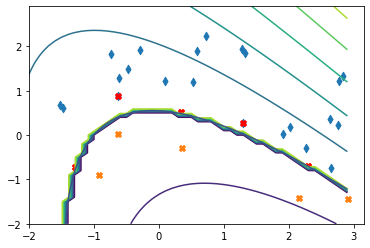

In [210]:
#매쉬그리드 데이터 생성
X1, X2 = np.meshgrid(S1, S2)
plt.contour(X1.T, X2.T, F)  #결정 경계 그리기
plt.contour(X1.T, X2.T, G)  #판별함수의 등고선 그리기
posld = np.argwhere(Y.reshape(-1)>0); negld = np.argwhere(Y.reshape(-1)<0)
plt.scatter(X[posld,0], X[posld,1], marker='d')
plt.scatter(X[negld,0], X[negld,1], marker='X')
plt.scatter(X[svi,0], X[svi,1], marker='X', c='r')

plt.show()